Fitting 3 folds for each of 10 candidates, totalling 30 fits

✅ Best Params: {'subsample': 0.9, 'n_estimators': 500, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 1}
[0]	validation_0-rmse:2.18159
[1]	validation_0-rmse:2.08065
[2]	validation_0-rmse:1.98561
[3]	validation_0-rmse:1.89629
[4]	validation_0-rmse:1.81141
[5]	validation_0-rmse:1.73156
[6]	validation_0-rmse:1.65578
[7]	validation_0-rmse:1.58562
[8]	validation_0-rmse:1.51937
[9]	validation_0-rmse:1.45638
[10]	validation_0-rmse:1.39698
[11]	validation_0-rmse:1.34135
[12]	validation_0-rmse:1.28884
[13]	validation_0-rmse:1.24006


/usr/local/lib/python3.11/dist-packages/xgboost/sklearn.py:889: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[14]	validation_0-rmse:1.19376
[15]	validation_0-rmse:1.15061
[16]	validation_0-rmse:1.11068
[17]	validation_0-rmse:1.07367
[18]	validation_0-rmse:1.03970
[19]	validation_0-rmse:1.00649
[20]	validation_0-rmse:0.97619
[21]	validation_0-rmse:0.94893
[22]	validation_0-rmse:0.92221
[23]	validation_0-rmse:0.89880
[24]	validation_0-rmse:0.87702
[25]	validation_0-rmse:0.85587
[26]	validation_0-rmse:0.83718
[27]	validation_0-rmse:0.81908
[28]	validation_0-rmse:0.80306
[29]	validation_0-rmse:0.78805
[30]	validation_0-rmse:0.77420
[31]	validation_0-rmse:0.76264
[32]	validation_0-rmse:0.75142
[33]	validation_0-rmse:0.74049
[34]	validation_0-rmse:0.73019
[35]	validation_0-rmse:0.72155
[36]	validation_0-rmse:0.71357
[37]	validation_0-rmse:0.70613
[38]	validation_0-rmse:0.69982
[39]	validation_0-rmse:0.69285
[40]	validation_0-rmse:0.68717
[41]	validation_0-rmse:0.68253
[42]	validation_0-rmse:0.67791
[43]	validation_0-rmse:0.67385
[44]	validation_0-rmse:0.66942
[45]	validation_0-rmse:0.66637
[46]	val

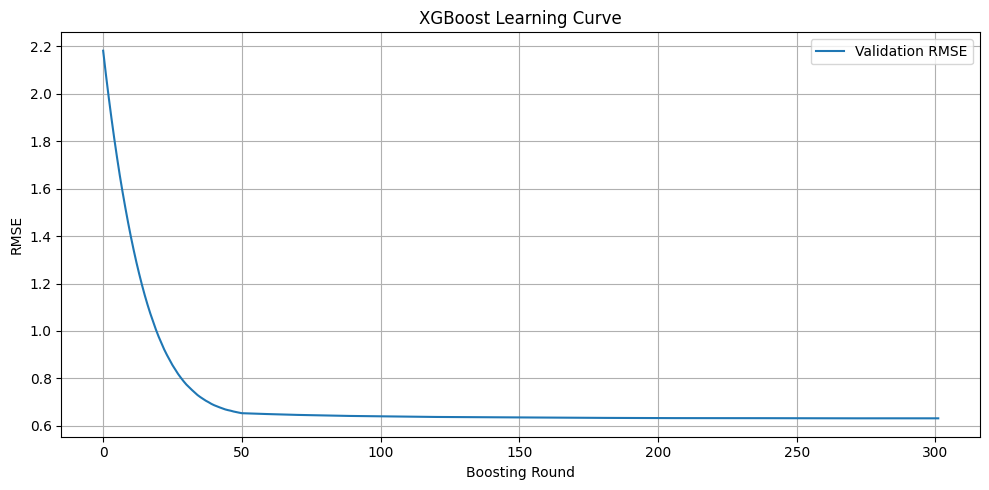

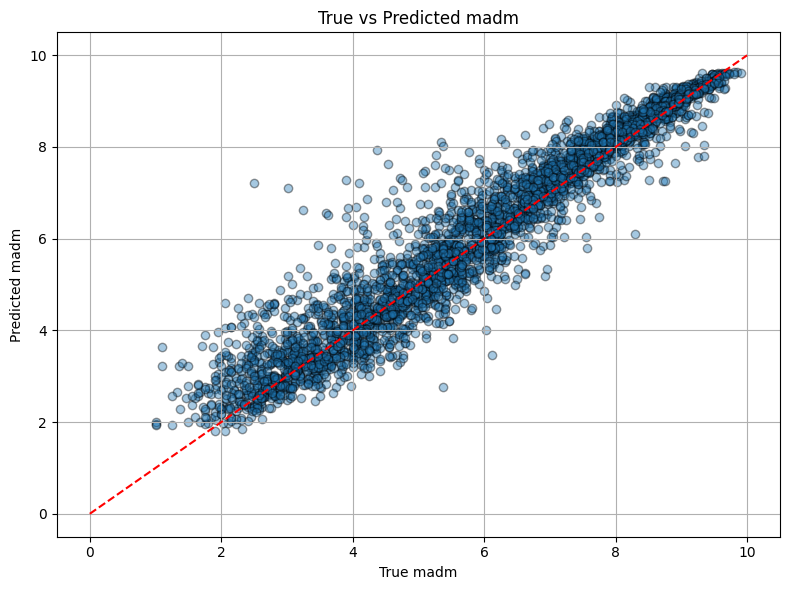

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from xgboost.callback import EarlyStopping, LearningRateScheduler
import category_encoders as ce

# LOAD AND CONCATENATE ALL CSV FILES
dfs = []
for year in range(2020, 2025):
    path = f"/kaggle/input/repartizare-files/repartizare{year}.csv"
    if os.path.exists(path):
        df = pd.read_csv(path)
        df["year"] = year
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# CLEAN & SORT TO GET LAST ADMITTED PER SCHOOL + SPECIALIZATION
df = df.dropna(subset=["madm", "h", "sp"])
df["madm"] = df["madm"].astype(float)
df["year"] = df["year"].astype(int)

df_sorted = df.sort_values(by=["year", "h", "sp", "madm"], ascending=[True, True, True, True])
df_last = (
    df_sorted
    .groupby(["year", "h", "sp"])
    .agg(last_madm=("madm", "min"))
    .reset_index()
)

# FEATURE ENGINEERING
df_last["avg_madm_school"] = df_last.groupby("h")["last_madm"].transform("mean")
df_last["avg_madm_sp"] = df_last.groupby("sp")["last_madm"].transform("mean")
df_last["count_per_school_sp"] = df_last.groupby(["h", "sp"])["last_madm"].transform("count")

# CATEGORICAL ENCODING PREP
df_last["h"] = df_last["h"].astype(str)
df_last["sp"] = df_last["sp"].astype(str)

# BUILD X and y
features = ["year", "h", "sp", "avg_madm_school", "avg_madm_sp", "count_per_school_sp"]
X = df_last[features]
y = df_last["last_madm"]

encoder = ce.TargetEncoder(cols=["h", "sp"])
X_encoded = encoder.fit_transform(X, y)

# TIME-AWARE SPLIT (train: 2020–2023, test: 2024)
train_mask = df_last["year"] < 2024
X_train = X_encoded[train_mask]
X_test = X_encoded[~train_mask]
y_train = y[train_mask]
y_test = y[~train_mask]

# HYPERPARAMETER TUNING
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [300, 500, 1000],
    'subsample': [0.8, 0.9, 1],
    'colsample_bytree': [0.8, 0.9, 1]
}

base_model = XGBRegressor(
    tree_method='hist',
    device='cuda',
    verbosity=0,
    eval_metric="rmse"
)

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Best model
model = random_search.best_estimator_
print("\n✅ Best Params:", random_search.best_params_)

callbacks = [
    EarlyStopping(rounds=30, save_best=True, min_delta=0.0001),
    LearningRateScheduler(lambda epoch: 0.05 if epoch < 50 else 0.01)
]

# FINAL TRAINING ON FULL TRAIN SET
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=callbacks,
    verbose=True
)

eval_result = model.evals_result()

# EVALUATION
y_pred = model.predict(X_test)
y_true = y_test

mae = mean_absolute_error(y_true, y_pred)
print(f"\n✅ Final MAE: {mae:.3f}")

# SAVE MODEL + ENCODER
joblib.dump((model, encoder, X_train.columns), "/kaggle/working/madm_predictor_tuned.pkl")

# PLOTS

# Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(eval_result["validation_0"]["rmse"], label="Validation RMSE")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("XGBoost Learning Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Predicted vs True
plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.4, edgecolors="k")
plt.plot([0, 10], [0, 10], 'r--')
plt.xlabel("True madm")
plt.ylabel("Predicted madm")
plt.title("True vs Predicted madm")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
model, encoder, feature_columns = joblib.load("/kaggle/working/madm_predictor_tuned.pkl")

# Új adatpont létrehozása
new_data = pd.DataFrame([{
    "year": 2025,
    "h": "<b>LICEUL HOREA, CLOȘCA ȘI CRIȘAN ABRUD</b><br/>Real/Liceal/Zi",
    "sp": "<b>(125) Matematică-Informatică</b><br/>Limba română"
}])

# Hozzáadjuk az aggregált jellemzőket
new_data["avg_madm_school"] = df_last[df_last["h"] == new_data["h"].iloc[0]]["last_madm"].mean()
new_data["avg_madm_sp"] = df_last[df_last["sp"] == new_data["sp"].iloc[0]]["last_madm"].mean()
new_data["count_per_school_sp"] = df_last[(df_last["h"] == new_data["h"].iloc[0]) &
                                          (df_last["sp"] == new_data["sp"].iloc[0])]["last_madm"].count()

# Kódolás (TargetEncoder-rel)
new_encoded = encoder.transform(new_data)

# Predikció
pred = model.predict(new_encoded)[0]
print(f"📊 Predicted last admitted average for 2025: {pred:.2f}")

# Egyedi iskolanevek
print("📚 Ismert iskolák (h):")
print(df_last["h"].unique())

# Egyedi szaknevek
print("\n📘 Ismert szakok (sp):")
print(df_last["sp"].unique())


📊 Predicted last admitted average for 2025: 8.63
📚 Ismert iskolák (h):
['<b>COLEGIUL AGRICOL DANIIL POPOVICI BARCIANU SIBIU</b><br/>Resurse naturale și protecția mediului/Liceal/Zi'
 '<b>COLEGIUL AGRICOL DANIIL POPOVICI BARCIANU SIBIU</b><br/>Servicii/Liceal/Zi'
 '<b>COLEGIUL AGRICOL DIMITRIE CANTEMIR, MUN. HUŞI</b><br/>Resurse naturale și protecția mediului/Liceal/Zi'
 ...
 '<b>SEMINARUL TEOLOGIC LICEAL ORTODOX „SFÂNTUL IOAN IACOB” DOROHOI</b><br/>Umanist/Liceal/Zi'
 '<b>SEMINARUL TEOLOGIC LICEAL „SF. IOSIF MĂRTURISITORUL" BAIA MARE</b><br/>Real/Liceal/Zi'
 '<b>SEMINARUL TEOLOGIC ORTODOX "SFÂNTUL SIMION ȘTEFAN" ALBA IULIA</b><br/>Umanist/Liceal/Zi']

📘 Ismert szakok (sp):
['<b>(106) Agricultură</b><br/>Limba română'
 '<b>(108) Protecţia mediului</b><br/>Limba română'
 '<b>(107) Comerţ</b><br/>Limba română' ...
 '<b>(276) Ştiinţe Sociale</b><br/>Limba română'
 '<b>(411) Ştiinţe ale Naturii</b><br/>Limba română'
 '<b>(412) Ştiinţe Sociale</b><br/>Limba română']


In [ ]:
df_last.to_csv("/kaggle/working/aggregated_last_admissions.csv", index=False)

In [8]:
model.get_booster().save_model("xgb_model.json")

In [9]:
joblib.dump((encoder, feature_columns), "encoder_and_features.pkl")

['encoder_and_features.pkl']